In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
from jax import lax, random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
#
n_samples = 100 + 1

phi = 0.7
theta = 0.3

noise_scale = 0.5


def generate_arma_1_1_data_for_loop(rng_key, n_samples, phi, theta, noise_scale):
    epsilon = noise_scale * random.normal(rng_key, (n_samples,))

    y = jnp.zeros(n_samples)

    for t in range(1, y.size):
        ar_part = phi * y[t - 1]
        ma_part = theta * epsilon[t - 1]
        y_t = ar_part + ma_part + epsilon[t]
        y = y.at[t].set(y_t)

    return y[1:]


y_foor_loop = generate_arma_1_1_data_for_loop(
    rng_key=rng_key, n_samples=n_samples, phi=phi, theta=theta, noise_scale=noise_scale
)

In [3]:
def generate_arma_1_1_data_scan(rng_key, n_samples, phi, theta, noise_scale):
    epsilon = noise_scale * random.normal(rng_key, (n_samples,))

    def arma_step(carry, noise):
        y_prev, epsilon_prev = carry
        ar_part = phi * y_prev + noise
        ma_part = theta * epsilon_prev
        y_t = ar_part + ma_part
        return (y_t, noise), y_t

    init_carry = (0.0, epsilon[0])
    _, y = lax.scan(arma_step, init_carry, epsilon[1:])
    return y


y_scan = generate_arma_1_1_data_scan(
    rng_key=rng_key, n_samples=n_samples, phi=phi, theta=theta, noise_scale=noise_scale
)

In [11]:
jnp.allclose(y_foor_loop, y_scan, atol=1e-5)

Array(True, dtype=bool)

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

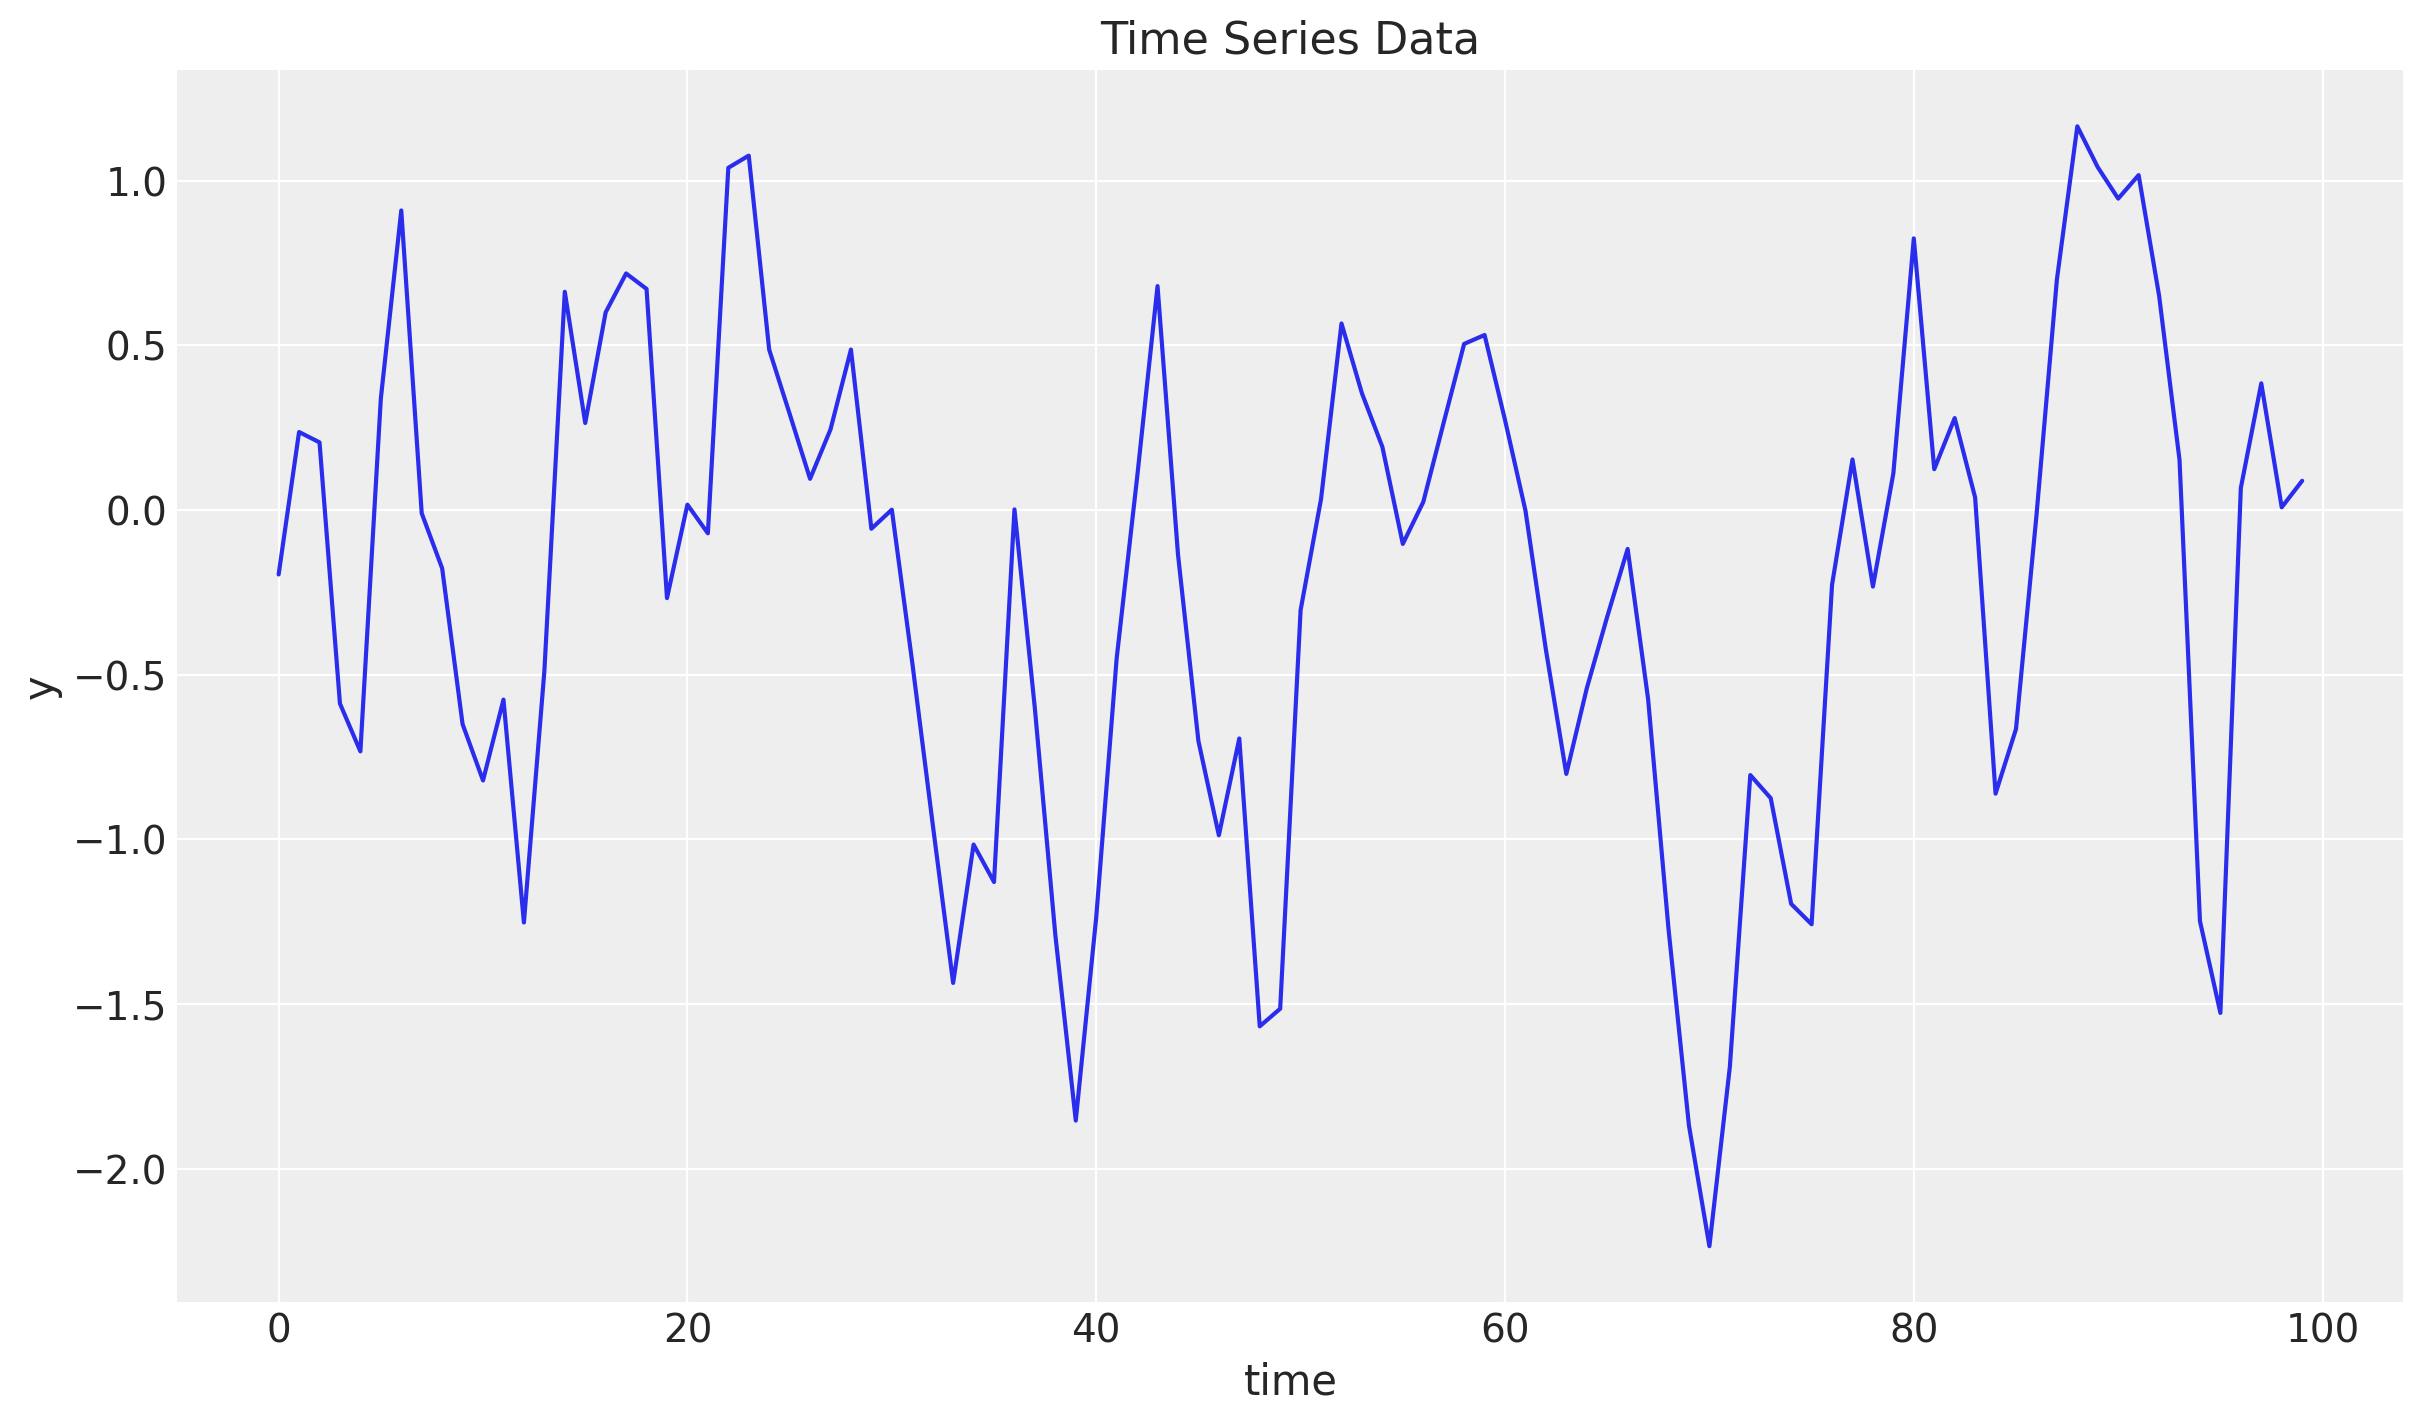

In [5]:
y = y_scan
t = jnp.arange(y.size)

fix, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

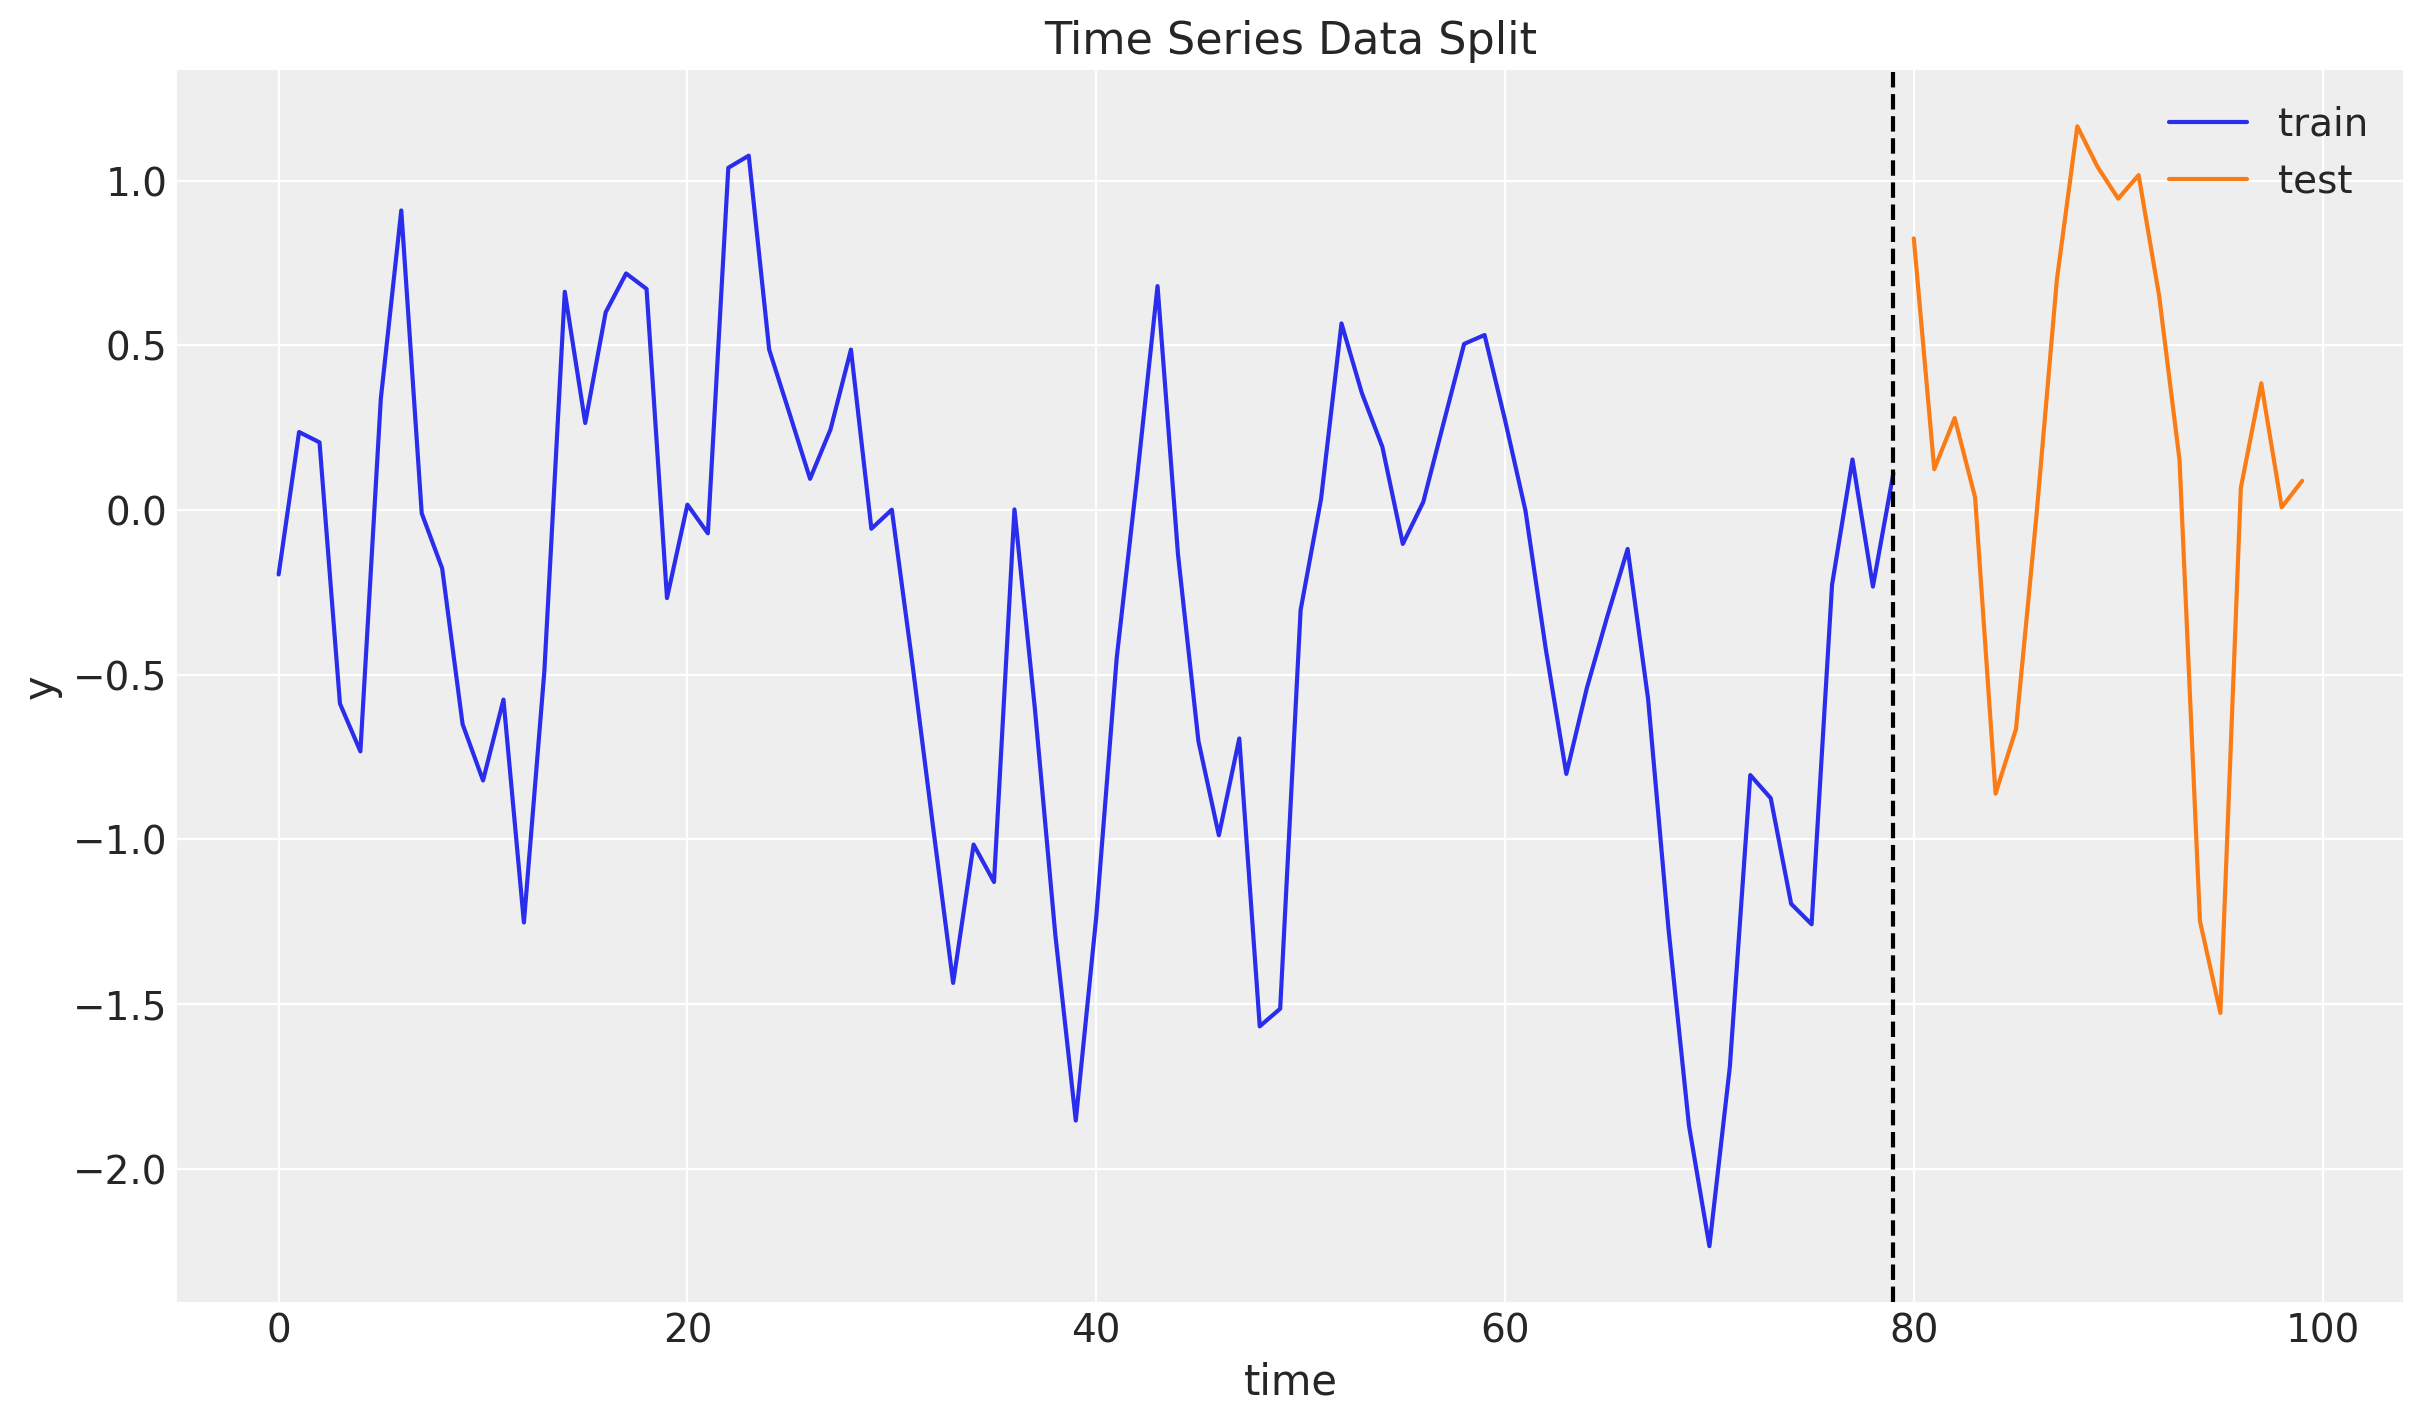

In [6]:
n = y.size

prop_train = 0.8
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

In [17]:
def arma_1_1(y: ArrayImpl, future: int = 0) -> None:
    phi = numpyro.sample("phi", dist.Normal(loc=0, scale=1))
    theta = numpyro.sample("theta", dist.Normal(loc=0, scale=1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    def transition_fn(carry, y):
        y_prev, error_prev = carry
        ar_part = phi * y_prev
        ma_part = theta * error_prev
        pred = numpyro.sample("pred", dist.Normal(loc=ar_part + ma_part, scale=sigma))
        error = y - pred

        return (y, error), error

    with numpyro.handlers.condition(data={"pred": y[1:]}):
        error_0 = y[0]

        _, errors = scan(
            transition_fn,
            (y[0], error_0),
            y[1:],
        )

    if future > 0:
        numpyro.deterministic("y_forecast", errors[-future:])

In [18]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [21]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, arma_1_1, inference_params, y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [22]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi,0.770,0.074,0.632,0.909,0.001,0.001,8148.0,5661.0,1.0
sigma,0.515,0.042,0.438,0.596,0.000,0.000,7643.0,5294.0,1.0
theta,-0.263,0.956,-2.033,1.541,0.010,0.010,8447.0,5723.0,1.0


In [23]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'Level Model Trace')

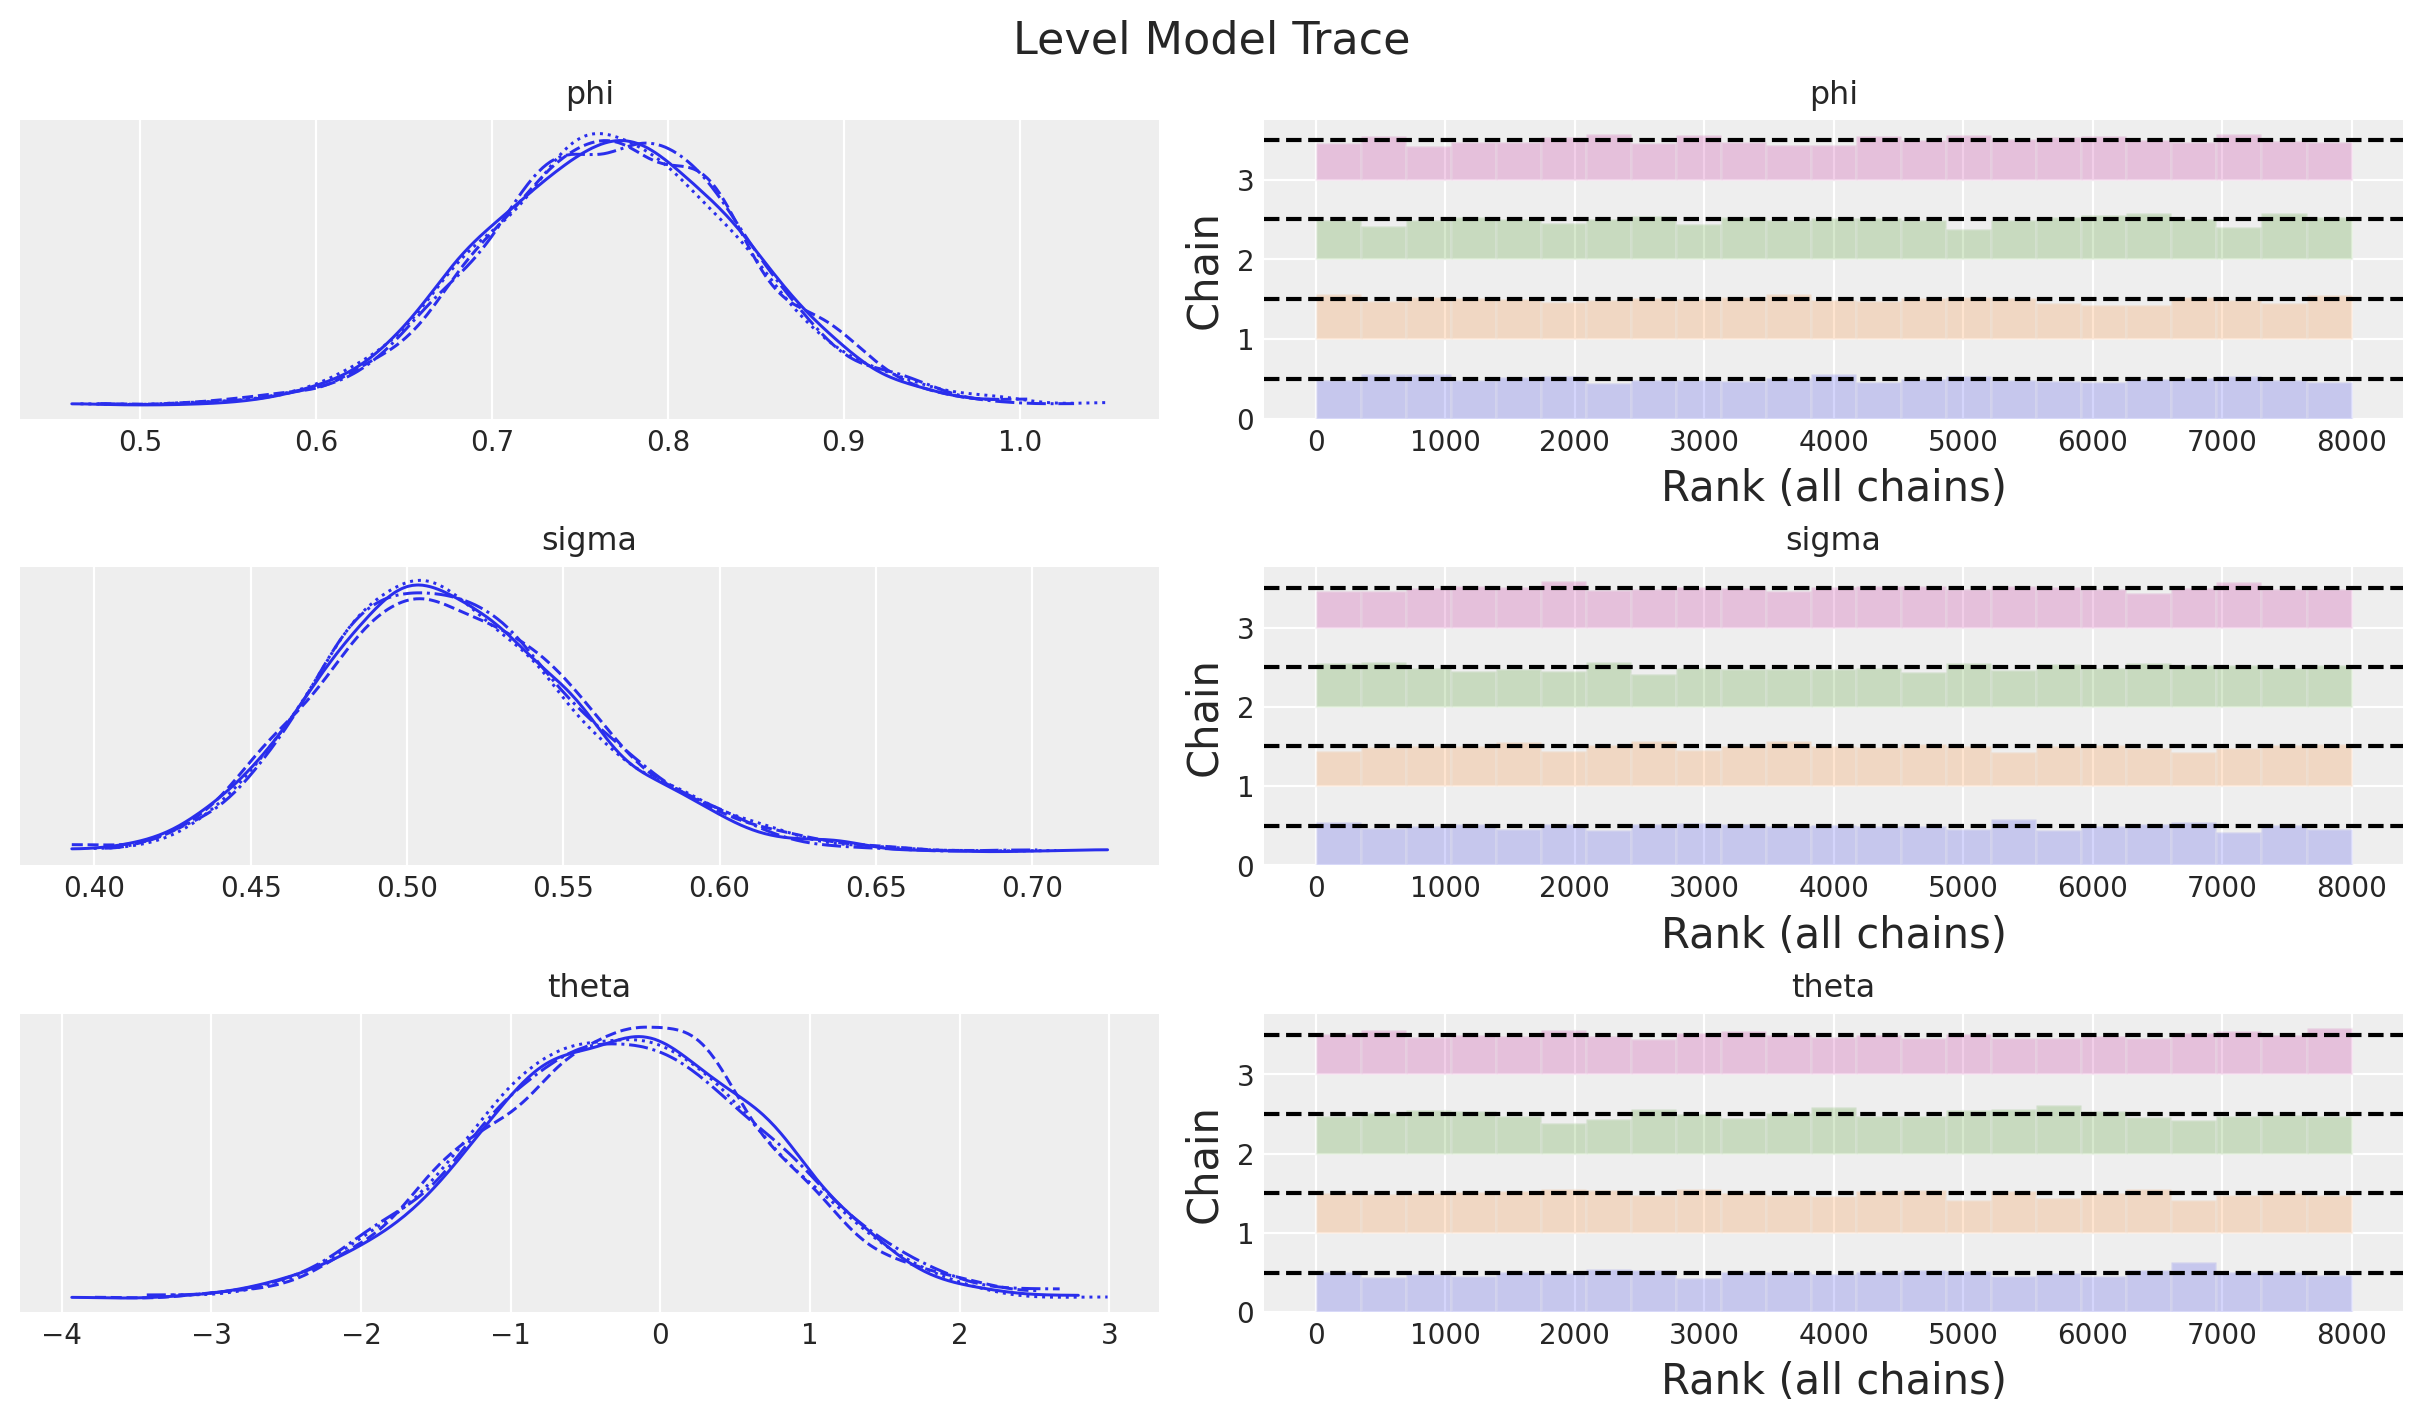

In [24]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Level Model Trace", fontsize=16)

In [26]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["y_forecast"],
    )
    return predictive(rng_key, *model_args)

In [28]:
rng_key, rng_subkey = random.split(key=rng_key)
forecast = forecast(rng_subkey, arma_1_1, mcmc.get_samples(), y_train, y_test.size)

In [29]:
posterior_predictive = az.from_numpyro(
    posterior_predictive=forecast,
    coords={"t": t_test},
    dims={"y_forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level Model Forecast')]

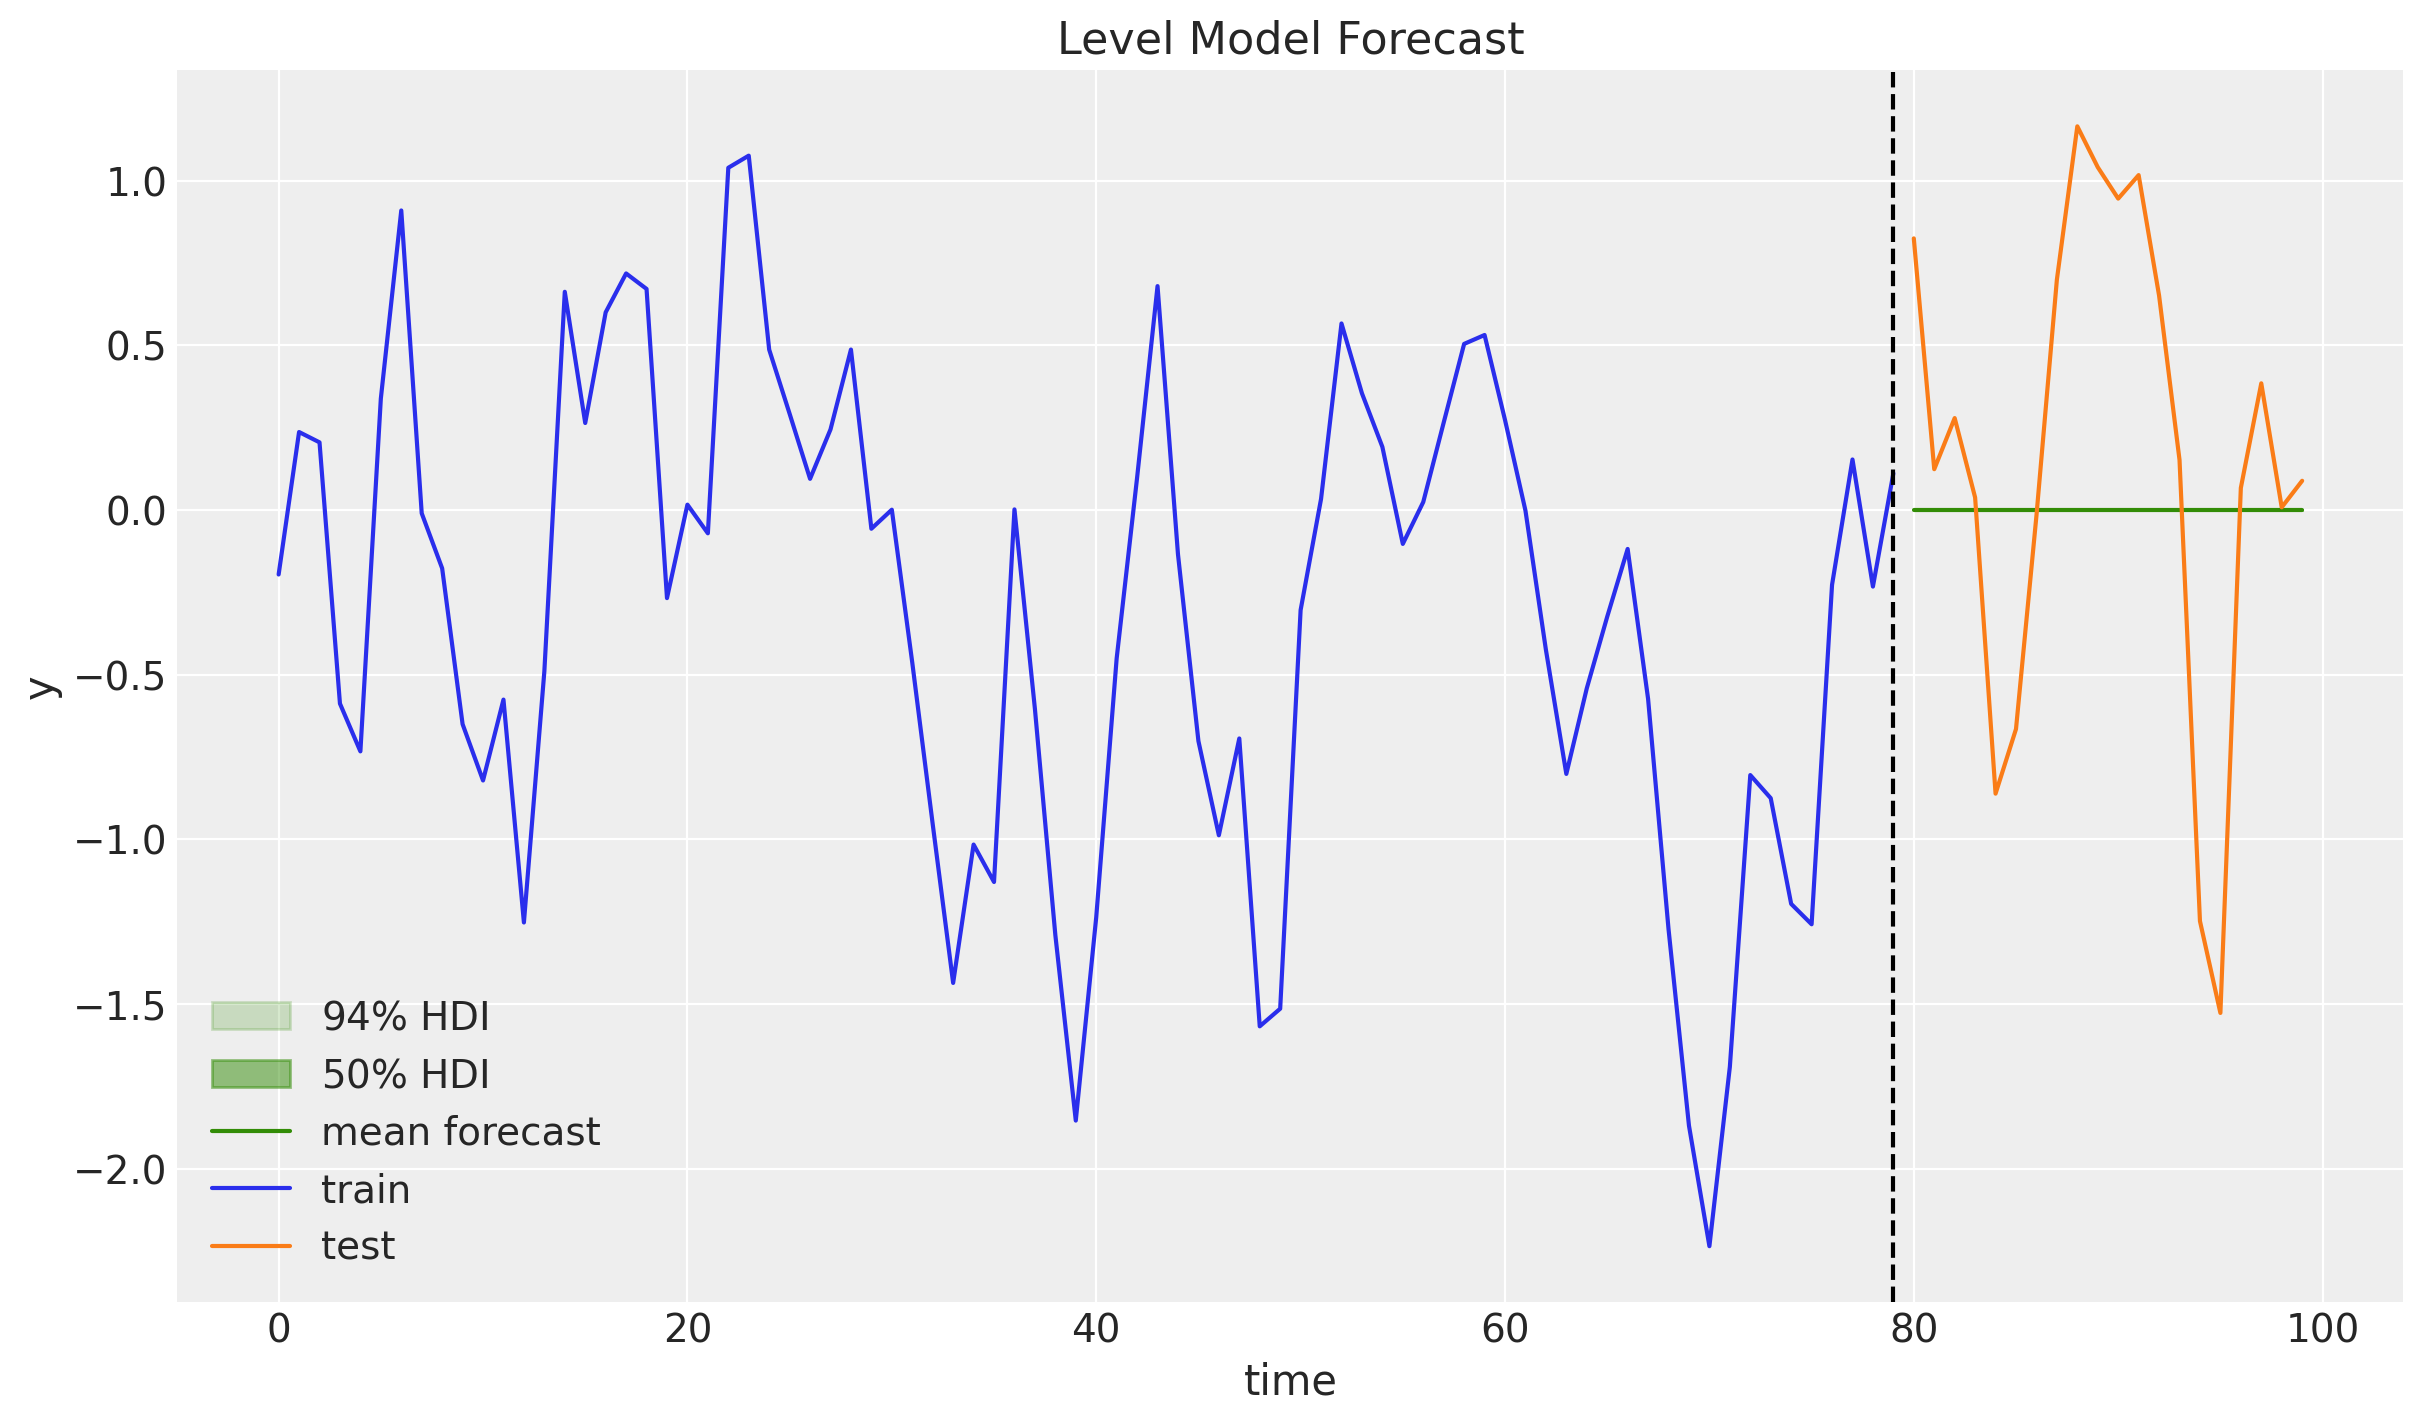

In [30]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level Model Forecast")